# 1 - Churn prediction project

In [58]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# To see more data
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


The data has a few coolumns

- CustomerID -- the ID of the customer
- Gender -- male/female
- Senior Citizen -- whether the customer is a senior citizen (0/1)
- Partner -- whether they live with a partner (yes/no)
- Dependents -- whether they have dependants (yes/no)
- Tenure -- number of months since the start of the contract
- Phone service -- whether they have phone services (yes/no)
- Multiple lines -- whether they have multiple phone lines (yes/no/no phone service)
- Internet service -- the type of internet service (no/fiber/optic)
- Online security -- if online security is enabled (yes/no/no internet)
- Online backup -- if online bakup service is enabled (yes/no/no internet)
- Device protection -- if the device protection service is enabled (yes/no/no internet)
- Tech support -- if the customer have tech support (yes/no/no internet)
- Streaming TV -- if the TV streaming service is enabled (yes/no/no internet)
- Streaming movies -- if the moovie streaming service is enabled (yes/no/no internet)
- Contract -- the type of contract (monthly/yearly/two years)
- Paperless billing -- if the billing is paperless (yes/no)
- Payment method -- payment method (electronic check, mailed check, bank transfer, credit card)
- Monthly charges -- the amount charged monthly (numeric)
- Total charges -- the total amount charged (numeric)
- Churn -- if the client has canceled the contract (yes/no)

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Convert the column TotalCharges to numeric
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce') # errors='coerce' to replace all non-numeric values with a NaN

# To confirm that there are non-numeric characters in the data
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [6]:
# Convert the column TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Set the missing values to 0
df.TotalCharges = df.TotalCharges.fillna(0)

In [7]:
# Make the column_names uniform
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
# Convert the target to number (0 for no and 1 for yes)
df.churn = (df.churn == 'yes').astype(int)

In [9]:
# Split the data in train, validation and test
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1) # random_state=1 Controlls the shuffling before the split 
# Set the random seed to ensure that the result is the same at each code run
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# Take the churn column and save it out of the dataframe
y_train = df_train.churn.values
y_val = df_val.churn.values

# Delete the churn column to avoid confusion
del df_train['churn']
del df_val['churn']

### Exploratory data analysis

In [10]:
# The missing values
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [11]:
# The distribution of the target
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

The data is imbalanced

In [12]:
# Separate the categorical and the numerical features in two lists
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice',
                'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
                'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [13]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

#### Feature importance

In [14]:
# Check the importance of the gender feature

# Check the churn rate for all female customers
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print("gender == female: {:.3f}".format(female_mean))

# Check the churn rate for all male customers
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print("gender == male: {:.3f}".format(male_mean))

gender == female: 0.277
gender == male: 0.263


Knowing the gender of the customer doesn't help ientify whether they will churn

In [15]:
# Check the importance of the partner feature

# Check the churn rate if partner == yes
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print("partner == yes: {:.3f}".format(partner_yes))

# Check the churn rate if partner == no
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print("partner == no: {:.3f}".format(partner_no))

partner == yes: 0.205
partner == no: 0.330


The partner variable is useful for predicting churn

#### _RISK RATIO_

It's interesting to look at the ratio between the group rate and the global rate. In statistics, the ratio between probabilities in different groups is called risk ratio. In our case, the risk of churning is :

<center>risk = group rate / global rate</center>

In [16]:
# Calculate the global churn rate
global_mean = df_train_full.churn.mean()
# Compute the AVG(churn)
df_group = df_train_full.groupby(by='gender').churn.agg(['mean'])
# Calculate the difference between group churn rate and global rate
df_group['diff'] = df_group['mean'] - global_mean
# Calculate the risk of churning
df_group['risk'] = df_group['mean'] / global_mean

df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [17]:
from IPython.display import display

# Loop over all categorical variables
for col in categorical:
    # Perform group by for each categorical variable and calculate the difference and the rate
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['rate'] = df_group['mean'] / global_mean
    # Display the resulting dataframe
    display(df_group)

,mean,diff,rate
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,rate
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,rate
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,rate
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,rate
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,rate
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,rate
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,rate
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,rate
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,rate
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,rate
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,rate
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,rate
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,rate
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,rate
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,rate
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


From the results we learn that :

- For gender, there is no much difference between males and females
- Senior citizens tend to churn more than nonseniors
- People with a partner churn less than people with no partner
- People who use phone service are not at risk of churning
- People with no tech support tend to churn more than those who do
- People with monthly contracts cancel the contract a lot more often than others, and people with two-year contracts churn very rarely

#### _Mutual Information_

We can measure the degree of dependency between a categorical variable and the target variable using the metrics of importance. If two variables are dependent, knowing the value of one variable gives us some information about another. On the other hand, if a variable is completely independant of the target variable, it's not useful and can be safely removed from the dataset.

For categorical variables, one such metric is mutual information, which tells how much information we learn about one variable if we got to learn the value of the other variable. In machine learning, we often use it to measure the mutual dependency between two variables.

Higher values of mutual information mean a higher degree of dependence and lower values mean that the two variables are independent, so the variable will not be very useful for predecting the target.

In [18]:
# Create a stand-alone function for calculating mutual information
def calculate_mi(series):
    """Use the mutual_info_score function from sklearn"""
    return mutual_info_score(series, df_train_full.churn)

# Apply the function to each categorical column of the dataset
df_mi = df_train_full[categorical].apply(calculate_mi)
# Sort values of the result
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


The most useful features according to the mutual information score are contract, onlinesecurity, techsupport, internetservice and online backup

The least useful features according to the mutual information score are partner, seniorcitizen, multiplelines, phoneservice and gender

#### _CORRELATION COEFFICIENT_

In [19]:
# Corr
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

# 2 - Feature engineering

#### _One-hot encoding_

In [20]:
# Covert the dataframe to a list of dictionaries
train_dict = df_train[categorical + numerical].to_dict(orient='rows')

In [21]:
train_dict[1]

{'gender': 'female',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'credit_card_(automatic)',
 'tenure': 60,
 'monthlycharges': 100.5,
 'totalcharges': 6029.0}

In [22]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [23]:
# Convert the dictionarie to a matrix
X_train = dv.transform(train_dict)
X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

In [24]:
dv.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

#### _Logistic regression_

In [25]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [26]:
# One-hot encoding
val_dict = df_val[categorical + numerical].to_dict(orient='rows')
# Use the transform that was fitted previously
X_val = dv.transform(val_dict)

In [27]:
y_pred = model.predict_proba(X_val)
y_pred

array([[0.76509203, 0.23490797],
       [0.73114243, 0.26885757],
       [0.68054933, 0.31945067],
       ...,
       [0.9427494 , 0.0572506 ],
       [0.38477113, 0.61522887],
       [0.93872737, 0.06127263]])

In [28]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.23490797, 0.26885757, 0.31945067, ..., 0.0572506 , 0.61522887,
       0.06127263])

In [29]:
y_pred >= 0.5

array([False, False, False, ..., False,  True, False])

In [30]:
churn = y_pred >= 0.5

In [31]:
# Accuracy 
(y_val == churn).mean()

0.8016129032258065

#### _Model Interpretation_

In [32]:
# The bias
model.intercept_[0]

-0.121988402285897

In [33]:
# The weights of each feature
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


#### _Using the model_

In [34]:
# A customer to score
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75,
}

In [35]:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.07332403595205103

The probability that this customer will churn is about 7%, she's more likely to stay

In [36]:
# An other customer to score
customer = {
    'gender': 'female',
    'seniorcitizen': 1,
    'partner': 'no',
    'dependents': 'no',
    'phoneservice': 'yes',
    'multiplelines': 'yes',
    'internetservice': 'fiber_optic',
    'onlinesecurity': 'no',
    'onlinebackup': 'no',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'yes',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 85.7,
    'totalcharges': 85.7
}

In [37]:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.8321645264352351

With 83% of chance to churn

# 3 - Evaluation metrics for classification

#### _Accuracy_

In [38]:
# Get the predictions from the model
y_pred = model.predict_proba(X_val)[:, 1]
# Make "hard" predictions
churn = y_pred >= 0.5
# Compute the accuracy
(churn == y_val).mean()

0.8016129032258065

In [41]:
# Create an array with different thresholds
thresholds = np.linspace(0, 1, 11)

# Loop over each threshold value
for t in thresholds:
    # Use the accuracy_score function from scikit-learn for computing accuracy
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    # Print the thresholds and the accuracy values to standard output
    print("{:.2f} {:.3f}".format(t, acc))


0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


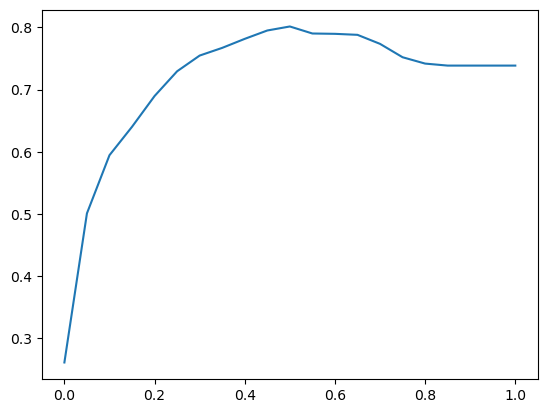

In [42]:
# Create different threshold values 
thresholds = np.linspace(0, 1, 21)
# Create an empty list to hold the accuraccy values
accuracies = []
for t in thresholds:
    # Calculate the accuracy for a given threshold
    acc = accuracy_score(y_val, y_pred >= t)
    # Record the accuracy for this threshold
    accuracies.append(acc)
# Plot the values
plt.plot(thresholds, accuracies)

#### _Confusion table (with Numpy)_

In [43]:
# Make predictions at threshold 0.5
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

# Get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

# Calculate true positives
true_positive = (predict_churn & actual_churn).sum()
# Calculate false positives
false_positive = (predict_churn & actual_no_churn).sum()

# Calculate false negatives
false_negative = (predict_no_churn & actual_churn).sum()
# Calculate true negatives
true_negative = (predict_no_churn & actual_no_churn).sum()

In [45]:
confusion_table = np.array(
    [[true_negative, false_positive],
    [false_negative, true_positive]]
)
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [46]:
# Computing the confusion table for different thresholds

# Create a list to keep the results
scores = []

# Create an array with different threshold values and loop over them
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # Compute the confusion table for for predictions at each threshold
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    # Append the results to the score list
    scores.append((t, tp, fp, fn, tn))

In [50]:
# Turn the list into a pandas dataframe
df_scores = pd.DataFrame(scores)
# Assign names to the columns of the dataframe
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [51]:
# True positive rate
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
# False positive rate
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


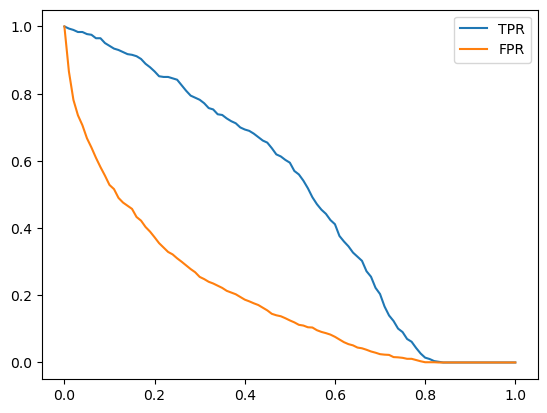

In [52]:
# Plot the results
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

#### _ROC curve_

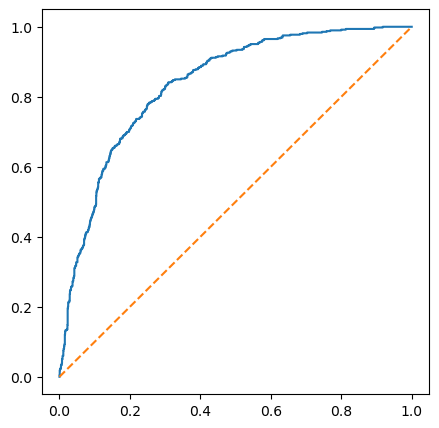

In [55]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='dashed')

#### _k-fold cross-validation_

In [56]:
def train(df, y):
    """Training the model"""
    # Apply one-hot encoding
    cat = df[categorical + numerical].to_dict(orient='rows')

    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # Train the model
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model

In [57]:
def predict(df, dv, model):
    """Applying the model to new data"""
    # Apply the same one-hot encoding scheme as in training
    cat = df[categorical + numerical].to_dict(orient='rows')

    X = dv.transform(cat)
    # Use the model to make predictions
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [59]:
# Use KFold class to split the data into 10 parts
from sklearn.metrics import roc_auc_score


kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Create a list for storing the results
aucs = []

# Iterate over the 10 different splits of the data
for train_idx, val_idx in kfold.split(df_train_full):
    # Split the data into train and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    # Train the model and make predictions 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    # Evaluate the quality of the train model on the validation data using AUC
    auc = roc_auc_score(y_val, y_pred)
    # Save the AUC to the list with the results
    aucs.append(auc)


In [60]:
# The mean and the standard deviation
print("auc = {:.3f} ± {:.3f}".format(np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


In [63]:
def train(df, y, c):
    """Function for training the model with parameter C for controlling regularization"""

    cat = df[categorical + numerical].to_dict(orient='rows')

    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # Use the c parameter during training
    model = LogisticRegression(solver='liblinear', C=c)
    model.fit(X, y)

    return dv, model

In [65]:
# Turning the model: selecting the best parameter c using cross-validation
nfolds = 10
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for c in [0.001, 0.01, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx].reset_index(drop=True)
        df_val = df_train_full.iloc[train_idx].reset_index(drop=True)

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, c=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print("c = {}, auc = {:.3f} ± {:.3f}".format(c, np.mean(aucs), np.std(aucs)))

c = 0.001, auc = 0.827 ± 0.002
c = 0.01, auc = 0.843 ± 0.001
c = 0.5, auc = 0.846 ± 0.001
c = 1, auc = 0.846 ± 0.001
c = 10, auc = 0.846 ± 0.001


In [66]:
# Full retrain
y_train = df_train_full.churn.values
y_test = df_test.churn.values

# Train the model on the full training dataset
dv, model = train(df_train_full, y_train, c=0.5)
# Apply it to the dataset
y_pred = predict(df_test, dv, model)

# Evaluate yje predictions on the datasets
auc = roc_auc_score(y_test, y_pred)
print("auc = {:.3f}".format(auc))

auc = 0.858
